### Make necessary imports

In [24]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../batchflow')

from batchflow import Config, Pipeline, B, V
from batchflow.opensets import MNIST
from batchflow.models.torch import TorchModel
from batchflow.models.metrics import ClassificationMetrics

### Load dataset

In [25]:
mnist = MNIST()

### Define model configs

In [26]:
config = {
    'inputs': dict(images={'shape': (1, 28, 28),
                           'data_format': 'channels_first'},
                   labels={'classes': 10}),
    'initial_block/inputs': 'images',
    'body/layout': 'f',
    'body/units': 10,
    'output': dict(predicted=['proba', 'labels']),
    'optimizer': 'Adam',
    'loss': 'ce',
}

### Define train pipeline

In [27]:
train_template = (Pipeline()
    .init_variable('loss', default=[])
    .to_array('float32', 'channels_first')
    .init_model('dynamic', TorchModel, 'model', config)
    .train_model('model', B.images, B.labels, fetches='loss', save_to=V('loss', mode='a'))
)

train_pipeline = mnist.train >> train_template

In [16]:
BATCH_SIZE = 64
N_ITERS = 1000
train_pipeline.run(batch_size=BATCH_SIZE, n_iters=N_ITERS, bar='n', shuffle=True, drop_last=True)

### Plot loss

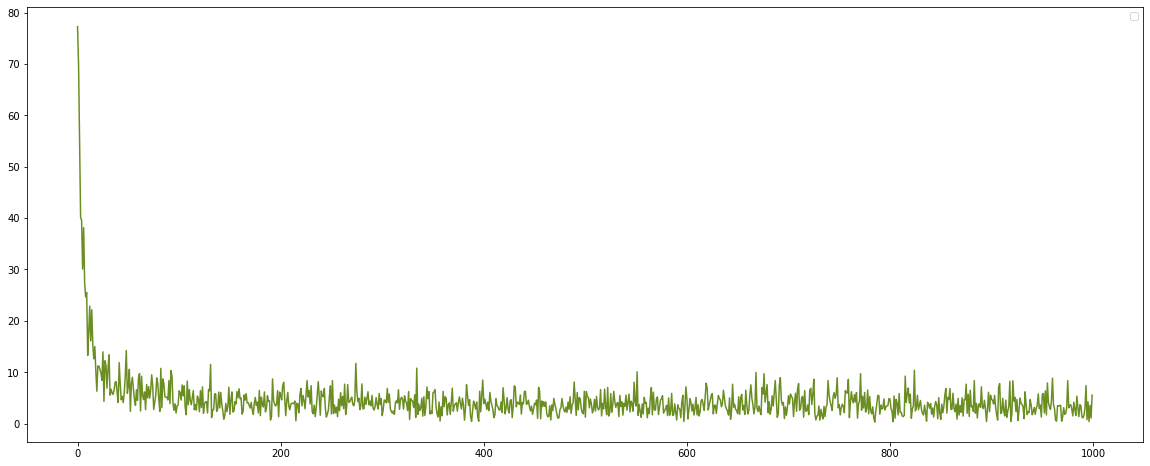

In [18]:
AVER = 10000

plt.figure(figsize=(20,8))
plt.legend(['f'])

loss = train_pipeline.v('loss')
aver = np.array([np.mean(l) for l in np.array_split(loss, AVER)])
plt.plot(aver, 'olivedrab')

### Define test template

In [19]:
test_template = (Pipeline()
    .init_variable('predictions')
    .init_variable('metrics', default=[])
    .import_model('model', train_pipeline)
    .to_array('float32', 'channels_first')
    .predict_model('model', B.images, fetches='predicted_proba', save_to=V.predictions)
    .gather_metrics(ClassificationMetrics, targets=B.labels, predictions=V.predictions, fmt='logits', axis=1, save_to=V('metrics', mode='a'))
)

test_pipeline = mnist.test >> test_template

In [20]:
test_pipeline.run(batch_size=1, n_epochs=1, bar='n')

### Plot confusion matrix

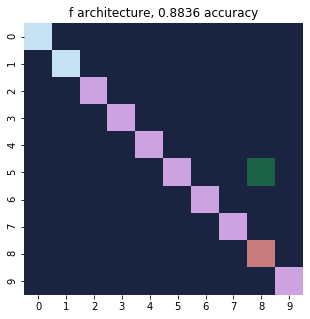

In [23]:
plt.figure(figsize=(5,5))
title = test_pipeline.m('model').config['body/layout']
metrics = test_pipeline.get_variable('metrics')
accuracy = np.mean([m.evaluate('acc') for m in metrics])
confusion_matrix = np.sum([m._confusion_matrix for m in metrics], axis=0).squeeze()
heatmap = sns.heatmap(confusion_matrix, cmap=sns.color_palette('cubehelix'), cbar=False).set_title('{} architecture, {} accuracy'.format(title, accuracy))